In [2]:
import torch
  
# Initializing input tensors
a = torch.tensor(15.0, requires_grad=True)
b = torch.tensor(20.0, requires_grad=True)
  
# Computing the output
c = a * b

# Gradients before backward()
print('Gradients before backprop')
print(f'Derivative of c with respect to a = {a.grad}')
print(f'Derivative of c with respect to b = {b.grad}')

# Computing the gradients
c.backward()

# Collecting the output gradient of the
# output with respect to the input 'a'
derivative_out_a = a.grad
  
# Collecting the output gradient of the
# output with respect to the input 'b'
derivative_out_b = b.grad
  
# Displaying the outputs
print('\nGradients after backprop')
print(f'Derivative of c with respect to a = {derivative_out_a}')
print(f'Derivative of c with respect to b = {derivative_out_b}')

# zero_grad()
# torch.optim.Optimizer.zero_grad() only works when optimizer is involved
print('\nGradients after zero_grad()')
print(f'Derivative of c with respect to a = {a.grad.zero_()}')
print(f'Print a grad again = {a.grad}') # Actually set to zero

Gradients before backprop
Derivative of c with respect to a = None
Derivative of c with respect to b = None

Gradients after backprop
Derivative of c with respect to a = 20.0
Derivative of c with respect to b = 15.0

Gradients after zero_grad()
Derivative of c with respect to a = 0.0
Print a grad again = 0.0


In [2]:
# You cannot run backwards again on c since dynamic graph is 
# only for one computation, then tensors are freed, new computation
# That is why we need the forward pass first which creates the 
# graph each time again for one batch of data. (input to Linear
# for example is (*,Hidden_size) so for batch)

print("Run backwards again")
c.backward()
print('\nGradients after second backprop')
print(f'Derivative of c with respect to a = {derivative_out_a}')
print(f'Derivative of c with respect to b = {derivative_out_b}')

Run backwards again


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [3]:
# Here we can see that the gradient for b was not reset to 0
# so the new gradient is old + new = 2*15
# Gradient is always connected to tensor

print("Run backwards again")
c = a*b
c.backward()
print('\nGradients after second backprop')
print(f'Derivative of c with respect to a = {derivative_out_a}')
print(f'Derivative of c with respect to b = {derivative_out_b}')

Run backwards again

Gradients after second backprop
Derivative of c with respect to a = 20.0
Derivative of c with respect to b = 30.0


In [4]:
fully_conn = torch.nn.Linear(in_features=2, out_features=5)
parameters = list(fully_conn.parameters())

In [5]:
# First: W with 5x2
print(parameters[0])

# Second: b with 5x1
parameters[1]

# Both have set requires grad to ture

Parameter containing:
tensor([[ 0.1237,  0.6240],
        [ 0.3935,  0.6649],
        [-0.5858,  0.4895],
        [ 0.3314, -0.3378],
        [-0.0191,  0.6745]], requires_grad=True)


Parameter containing:
tensor([ 0.3232, -0.1731, -0.2991, -0.1396,  0.1020], requires_grad=True)

In [6]:
a = torch.tensor([1,2,34], dtype=torch.float32, requires_grad=True)
print(a.grad)

# Gradient is set to None by default

None


In [7]:
# In a dataloader the tensors for inputs/labels are created but it is 
# set to FALSE as default, so there will be no gradient computations for
# the input data (this would harm the efficiency)
x = torch.tensor([1,2,3], dtype=torch.float32)
w = torch.tensor([1,1,2], dtype=torch.float32, requires_grad=True)

# These computations do nothing! Only if assigned to new tensor
print(x @ w)
print(torch.matmul(x,w))
print(x.T @ w)

y = x @ w
y.backward()

print(w.grad)
print(x.grad)

tensor(9., grad_fn=<DotBackward0>)
tensor(9., grad_fn=<DotBackward0>)
tensor(9., grad_fn=<DotBackward0>)
tensor([1., 2., 3.])
None


/var/folders/ds/ccqkblhx43bf8fpz7y_2_kj80000gn/T/ipykernel_56425/3508248262.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  print(x.T @ w)


In [8]:
# Try out the with no grad:
# First case: The gradient of z and y wrt w is added 
x = torch.tensor([1,2,3], dtype=torch.float32)
w = torch.tensor([1,1,2], dtype=torch.float32, requires_grad=True)

y = x @ w
z = x @ w
y.backward()
z.backward()
print(w.grad)

tensor([2., 4., 6.])


In [9]:
# Second case: Gradient comps for z are turned off
x = torch.tensor([1,2,3], dtype=torch.float32)
w = torch.tensor([1,1,2], dtype=torch.float32, requires_grad=True)

y = x @ w

with torch.no_grad():
    z = x @ w

y.backward()
# z.backward()

print(w.grad)

# If we do not execute z.backward() it will change nothing in behaviour but under the hood
# there will be another (part) of the computational graph that tracks gradients for z! 
# Even though it might not be executed but the computaitons are saved etc. 

tensor([1., 2., 3.])


When does torch.no_grad() makes sense? 
- for evaluation for sure, I think memory allocation is already done when computation is done together with the graph (all instructions ho wto compute grad), the execution of it, so the actual computation is triggered when .backward() is called. no_grad will allow for bigger batch sizes in eval phase
- in example above, the efficiency was kind of similar, but what happens if you have some weights that are fixed for you. Even if you do not update them, computing the loss will always trigger the gradient computations for them as well! So you should always use no_grad if possible.  **But: If it is an intermediate result you actually need for the gradient comps** , e.g. you need dlayer/dw and dlayer/dlayer_before_output - each weight working in the same direction. The effects (we are talking about bs=1) will all be in the same direction! w1 higher = w2 higher, w2higher = loss smaller so both at the same time = loss down (if the step is reasonably small)

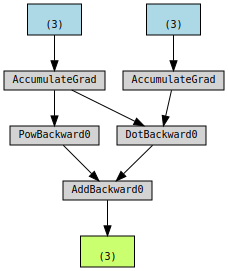

In [10]:
import torchviz 

x = torch.tensor([1,2,3], dtype=torch.float32, requires_grad=True)
w = torch.tensor([1,1,2], dtype=torch.float32, requires_grad=True)

y = x @ w
z = x**2
res = y + z
# torchviz.make_dot(y, show_attrs=True, show_saved=True)
torchviz.make_dot(res)

# Makes sense since x is influencing y and z!

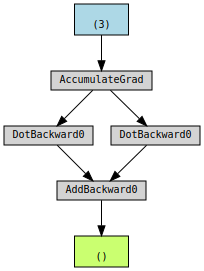

In [11]:
x = torch.tensor([1,2,3], dtype=torch.float32, requires_grad=False)
w = torch.tensor([1,1,2], dtype=torch.float32, requires_grad=True)

y = x @ w
z = x @ w
res = y + z
torchviz.make_dot(res)

# Lefs represent the trainable parameters, here x is not trainable

In [12]:
y = x @ w
z = x @ w
res = y + z
res.backward()  # This works since the comp graph is created from operations! 
print(w.grad)

y = 10*x@w
z = x @ w
res = y + z
res.backward()
print(w.grad)

# We can alter the formulation and still backward it to acqiure gradient, new graph is built!

tensor([2., 4., 6.])
tensor([13., 26., 39.])


- AccumulateGrad is accumulating the grads for this leaf node (weights) over the batch (num times it is called before zero_gradding)

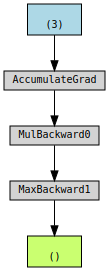

In [13]:
x = torch.tensor([1,2.1,3], dtype=torch.float32, requires_grad=False)
w = torch.tensor([1,3,2], dtype=torch.float32, requires_grad=True)

z = torch.max(x*w)
z.backward()

torchviz.make_dot(z)

# Makes sense since x is influencing y and z!

In [14]:
w.grad

# Gradient for operation just ignores all other inputs and just lets the gradient flow 
# backwards from this hihgest input

tensor([0.0000, 2.1000, 0.0000])

In [15]:
# What happens with gradient during indexing
x = torch.tensor([1,2,3], dtype=torch.float32, requires_grad=False)
w = torch.tensor([1,5,7], dtype=torch.float32, requires_grad=True)

z = w*x
result = z[1]

print(result.requires_grad)

result.backward()
w.grad

# Identity function for one element! So gradient flows only back from this element (basically 0*x_0*w_0!)

True


tensor([0., 2., 0.])

In [13]:
# What happens with gradient during indexing
x = torch.tensor([1,2,3], dtype=torch.float32, requires_grad=False)
w = torch.tensor([1,5,7], dtype=torch.float32, requires_grad=True)

z = x + w 
print(z)
print(z.requires_grad)

res = z.gather(0, index=torch.tensor(1))
res.backward()
w.grad

# The gradient only flows from the second element in z since 
# it is gathered, rest is not relevant

tensor([ 2.,  7., 10.], grad_fn=<AddBackward0>)
True


tensor([0., 1., 0.])

In [7]:
# What happens if on GPU and then numpy?

def process(a, b):
    c = a+b
    # c = c.to("cpu")
    c = c.numpy()
    return c.sum()

a = torch.tensor([15, 20, 30])
b = torch.tensor([150, 200, 300])

a = a.to("mps")
b = b.to("mps")

process(a,b)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Working with 3D tensors

In [2]:
import torch 
a = torch.Tensor([1,2,3,4,5])
b = torch.Tensor([10,20,30,40,50]).requires_grad_()
c = torch.Tensor([1,2,3,4,5])

stack = torch.stack([a,b,c],dim=1)
print(stack)
print(b.requires_grad)

res = stack @ torch.Tensor([1,3,1])
res = res.sum()
res.backward()

print(a.grad)
print(b.grad)

tensor([[ 1., 10.,  1.],
        [ 2., 20.,  2.],
        [ 3., 30.,  3.],
        [ 4., 40.,  4.],
        [ 5., 50.,  5.]], grad_fn=<StackBackward0>)
True
None
tensor([3., 3., 3., 3., 3.])


In [93]:
a = torch.Tensor([[1,2,3,4,5], [-1,-2,-3,-4,-5]])
b = torch.Tensor([[10,20,30,40,50], [0.1,0.2,0.3,0.4,0.5]]).requires_grad_()
c = torch.Tensor([[100,200,300,400,500], [11,21,31,41,51]])

res = torch.stack([a,b,c], dim=1)
res.shape
# (2,3,5) - (batch_size, q-heads, actions)

torch.Size([2, 3, 5])

In [94]:
# Now lets gather the right actions
actions = torch.tensor([1,0])  # Action 1 for batch 1, 0 for batch 2
actions = actions.unsqueeze(1).unsqueeze(2)
torch.gather(res, dim=2, index=actions).shape

torch.Size([2, 1, 1])

In [95]:
# The index must be of size that we want.
# We want (batch_size, num_heads, 1) so gather along 2
# Index needs to be of same size so (2, 3, 1)
# https://medium.com/@mbednarski/understanding-indexing-with-pytorch-gather-33717a84ebc4

actions = torch.tensor([1,0]).unsqueeze(1)
idx = actions.repeat(1,3).unsqueeze(2)
result = torch.gather(res, dim=2, index=idx).squeeze()

In [96]:
torch.matmul(result, torch.tensor([1,1,1.0]))

tensor([222.0000,  10.1000], grad_fn=<MvBackward0>)

In [135]:
# Choose max action 
q_all = res
print(q_all.shape)

w = torch.tensor([0.1,0.5,0.4])
# We want (2,3,5) x (...) = (2,5)
res2 = torch.matmul(w, q_all).detach()

print(res2)

torch.Size([2, 3, 5])
tensor([[ 45.1000,  90.2000, 135.3000, 180.4000, 225.5000],
        [  4.3500,   8.3000,  12.2500,  16.2000,  20.1500]])


In [137]:
torch.argmax(res2, dim=1)

tensor([4, 4])

In [156]:
r_acc = torch.tensor([1,2,4])
r_div = torch.tensor([1,2,4])*10
r_nov = torch.tensor([1,2,4])*100
torch.stack([r_acc, r_div, r_nov], dim=1)

tensor([[  1,  10, 100],
        [  2,  20, 200],
        [  4,  40, 400]])

In [23]:
import torch

# Softmax
a=torch.tensor([1.0,1,1,1,5],requires_grad=True)

res = torch.nn.functional.softmax(a, dim=0)
final = 10+torch.log(res[-1])
final.backward()
print(a.grad)

tensor([-0.0171, -0.0171, -0.0171, -0.0171,  0.0683])


In [16]:
# Softmax
a=torch.tensor([1.0,1,1,1,0],requires_grad=True)

res = torch.nn.functional.softmax(a, dim=0)
final = 10+torch.log(res[-1])
final.backward()
print(a.grad)

tensor([-0.2289, -0.2289, -0.2289, -0.2289,  0.9158])


In [22]:
# Softmax
a=torch.tensor([1.0,1,1,1,-5],requires_grad=True)

res = torch.nn.functional.softmax(a, dim=0)
final = 10+torch.log(res[-1])
final.backward()
print(a.grad)

tensor([-0.2498, -0.2498, -0.2498, -0.2498,  0.9994])
